# GetAround Analysis Machine Learning Project

This project is for [JEDHA](https://www.jedha.co/) Data Science Full-Stack Bootcamp.


Let's start by installing and importing the necessary packages

In [69]:
#!pip install Boto3

In [74]:
import warnings
warnings.filterwarnings('ignore')

In [75]:
import pandas as pd
#import boto3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
import xgboost as xgb

import os
import joblib
%matplotlib inline

# Import the Dataset

In [142]:
pd.pandas.set_option('display.max_columns', None)
df = pd.read_csv("get_around_pricing_project.csv")

In [143]:
df.head()

,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [144]:
df.drop("Unnamed: 0",axis=1, inplace = True)

## PART 1 : EDA

In [145]:
print("Number of Cars:", df.shape[0])
print('Number of features:',df.shape[1])

Number of Cars: 4843
Number of features: 14


In [146]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe()

,mileage,engine_power,rental_price_per_day
count,4843.00,4843.00,4843.00
mean,140962.80,128.99,121.21
std,60196.74,38.99,33.57
min,-64.00,0.00,10.00
25%,102913.50,100.00,104.00
50%,141080.00,120.00,119.00
75%,175195.50,135.00,136.00
max,1000376.00,423.00,422.00


As seen above, there are only three numerical variables: mileage, engine_power and rental_price_per_day (our target variable).
- The average daily rental price of the cars in the dataset is 121.21USD. The maximum daily revenue a car holder gets from renting their car is 422USD.
- The value of minimum mileage is -64, so there must be an error in that data, on the other hand the maximum value is sort of extreme, being x10 higher, and more than x12 standard deviation away from the mean!!
- Average engine power is 129 while the car with the maximum engine power can do 423!

In [147]:
cat_vars = ["model_key", "fuel", "paint_color", "car_type"]

bool_vars = ['private_parking_available', 'has_gps', 'has_air_conditioning',
             'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires']
num_vars = ['mileage', 'engine_power']

features_list = cat_vars + bool_vars + num_vars
target = ['rental_price_per_day']

### Missing Data

In [148]:
print("Percentage of missing values: % ")
display(100*df.isnull().sum()/df.shape[0])

Percentage of missing values: % 


model_key                   0.00
mileage                     0.00
engine_power                0.00
fuel                        0.00
paint_color                 0.00
car_type                    0.00
private_parking_available   0.00
has_gps                     0.00
has_air_conditioning        0.00
automatic_car               0.00
has_getaround_connect       0.00
has_speed_regulator         0.00
winter_tires                0.00
rental_price_per_day        0.00
dtype: float64

There is no missing data. Let's look at the value distribution of each feature.

### Numerical variables:

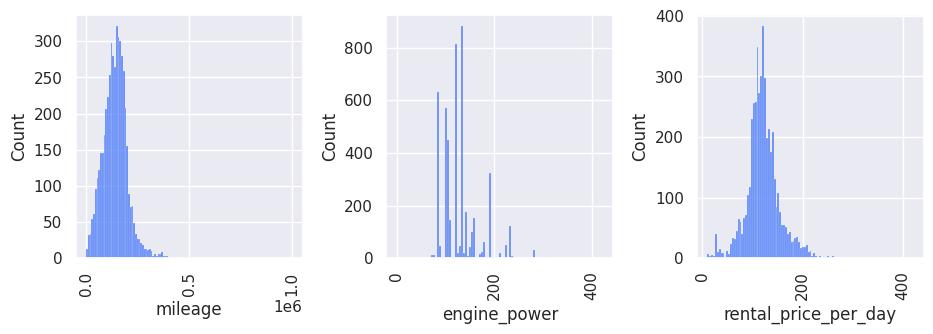

In [149]:
fig, axes = plt.subplots(1, 3, figsize=(9.5, 3.5))  # Creating subplots with 1 row and 2 columns
axes = axes.flatten()
sns.set_theme()
for i, column in enumerate(num_vars+target):
    sns.histplot(x=column, data=df, ax=axes[i], stat="count")
    axes[i].tick_params(axis='x', labelrotation=90)
# Adjust layout
plt.tight_layout()
plt.show()

Looking at the histrograms, we can conclude that mileage and rental prices show a somewhat normal distribution around the mean, on the other hand, engine power is far from a normal distribution.

While the majority of cars are distributed around between 0-50000 mileage, there are some extreme outliers as we have also seen in the descriptive statistics. I will keep this in mind when visualizing mileage variable.

### Categorical Variables:

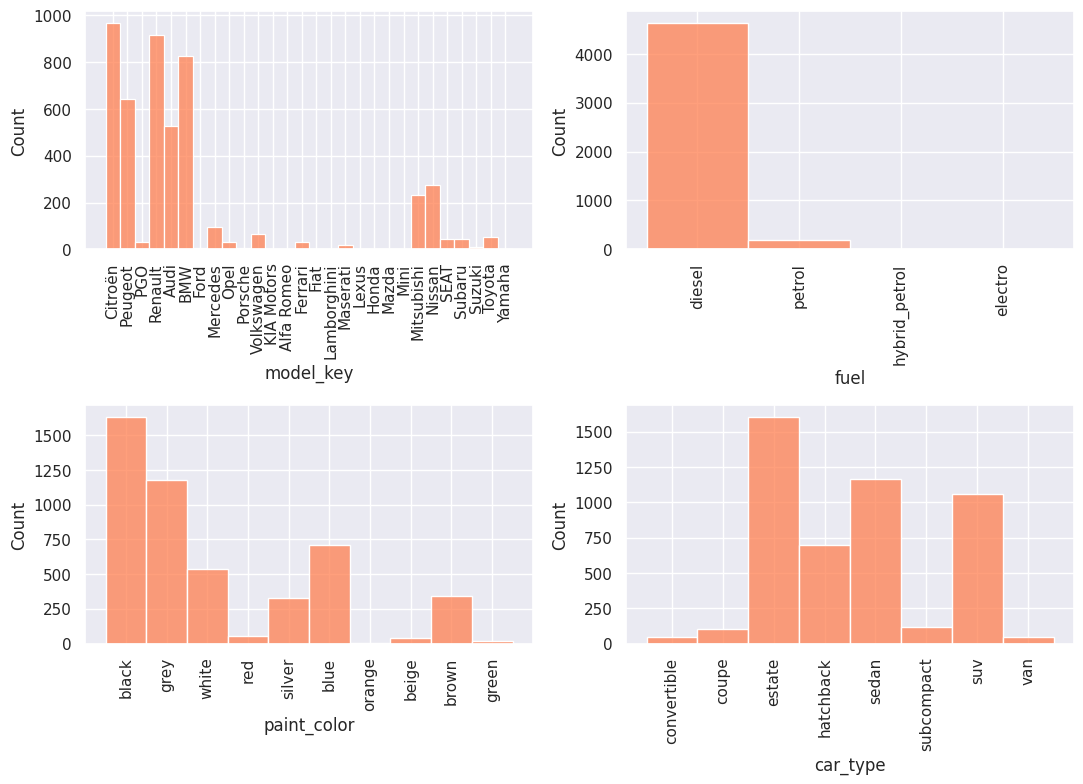

In [150]:
fig, axes = plt.subplots(2, 2, figsize=(11, 8))
axes = axes.flatten()
sns.set_theme()
for i, column in enumerate(cat_vars):
    sns.histplot(x=column, data=df, ax=axes[i], stat="count", color = 'coral')
    axes[i].tick_params(axis='x', labelrotation=90)
# Adjust layout
plt.tight_layout()
plt.show()


- Citroen, Renault and BMW are the top three most popular cars in our dataset. On the other hand there are models like Alfa Romeo, Suzuki and Yamaha which is quite rare among the GetAround users.
- An overwhelming majority of the cars use diesel, while electro and hybrid petrol cars are extremely rare.
- We cannot talk about an evenly distribution of colors either. Black being by far the most common color, it is followed by grey and blue while orange is quite infrequent.
- Estate, sedan and suv types are observed more than 1000 times each in the dataset, whereas the number of vans and convertible cars are less than a 100.

### Boolean Variables:

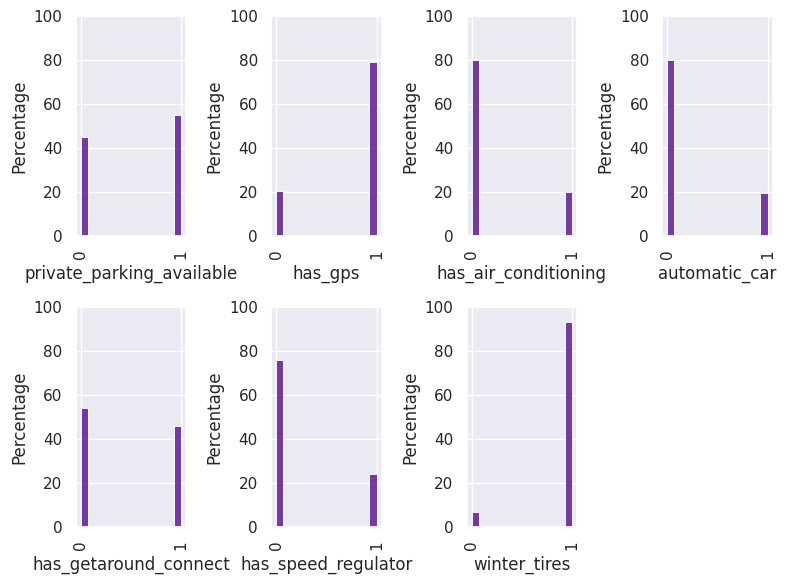

In [151]:
fig, axes = plt.subplots(2, 4, figsize=(8, 6))  # Creating subplots with 1 row and 2 columns
axes = axes.flatten()
sns.set_theme()
for i, column in enumerate(bool_vars):
  ax = ax=axes[i]
  sns.histplot(x=column, data=df, ax=ax, stat="percent", color = 'indigo')
  axes[i].tick_params(axis='x', labelrotation=90)
  ax.set_ylabel('Percentage')  # Adding ylabel as Percentage
  ax.set_ylim(0, 100)
fig.delaxes(axes[7])
# Adjust layout
plt.tight_layout()
plt.show()

- Only a small minority of cars don't have winter tires.
- GPS or air coinditioning both are features present in 80% of the cars (though they are not necessarily present in the same car).
- 80% of cars are automatic while more than 55 % has private parking available.
- The getaround_connect is available in less than half of the cars and only around 22% of the cars has speed regulator.

### Statistical Relationships
In this section I will visualize the statistical relationship of several features with the target vairable : daily rental price.

#### mileage:
Note that I will filter the mileage < 50000 for the sake of better plotting.

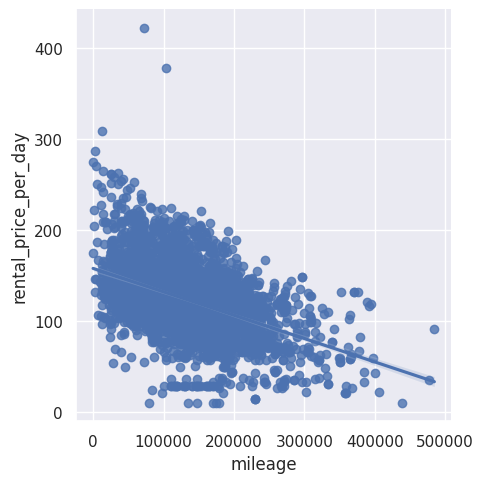

In [27]:
sns.lmplot(data=df[df['mileage'] < 500000], x="mileage", y="rental_price_per_day")


According to the lmplot, there is a negative correlation between mileage and daily rental price, the result is intuitive.

 #### engine_power

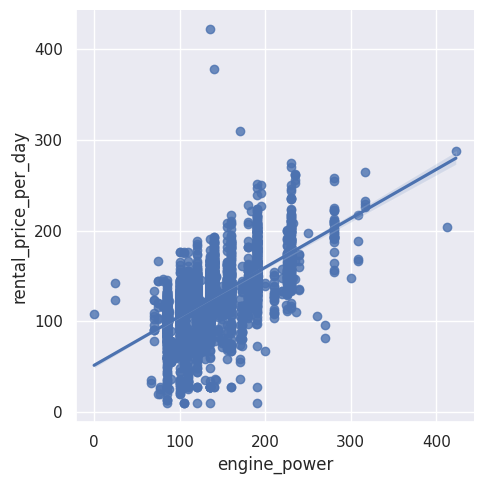

In [87]:
sns.lmplot(data=df, x="engine_power", y="rental_price_per_day")


# Adjust layout and display the plots
plt.tight_layout()
plt.show()

As one can expect, higher engine power seem to be positively correlated with higher prices.

#### Car model:

In [29]:
print("The number of model keys in the dataset is", len(set(df['model_key'])))

The number of model keys in the dataset is 28


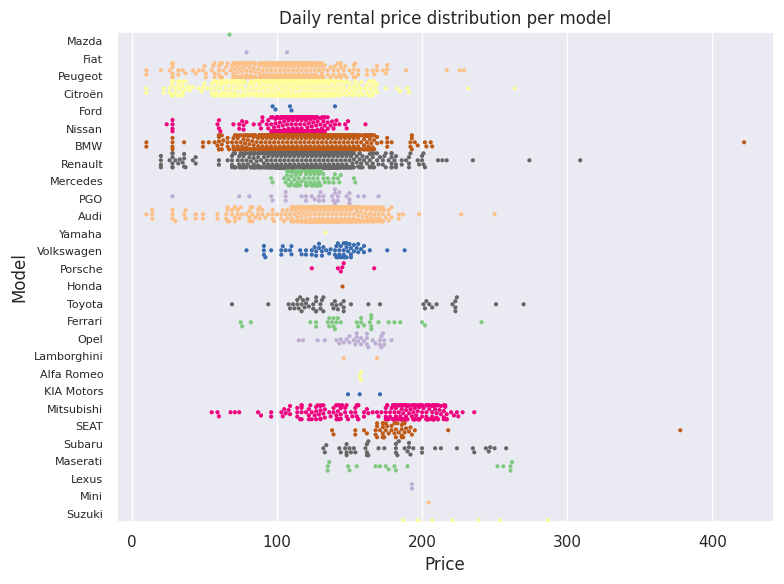

In [110]:
model_means = df.groupby('model_key')['rental_price_per_day'].mean().sort_values()

# Sort the DataFrame based on mean rental price
df_sorted = df.set_index('model_key').loc[model_means.index].reset_index()


plt.figure(figsize=(8, 6))

ax = sns.swarmplot(data=df_sorted, x="rental_price_per_day", y='model_key', dodge=True,palette='Accent', size=3)

plt.xlabel('Price')
plt.ylabel('Model')
plt.title('Daily rental price distribution per model')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

Models differ significantly in terms of average daily price and price variation. In the figure above is sorted by their average rental price in an ascending order.
- Suzuki appears as the model with highest daily rental price, however, it is good to remember that it is one of the most unfrequent models in our dataset, so this information itself shouldn't tell us much.
- Similarly, Mazda, which has the lowest mean, has a single occurence in the dataset while Fiat, the second lowest, has 2 occurences therefore that's not too much of an indicator either.
- If we look at the models that has enough representation in the dataset, Mitsubishi has a remarkably higher price whereas Peugeot and Citroen seems consistently affordable.

#### Paint color:

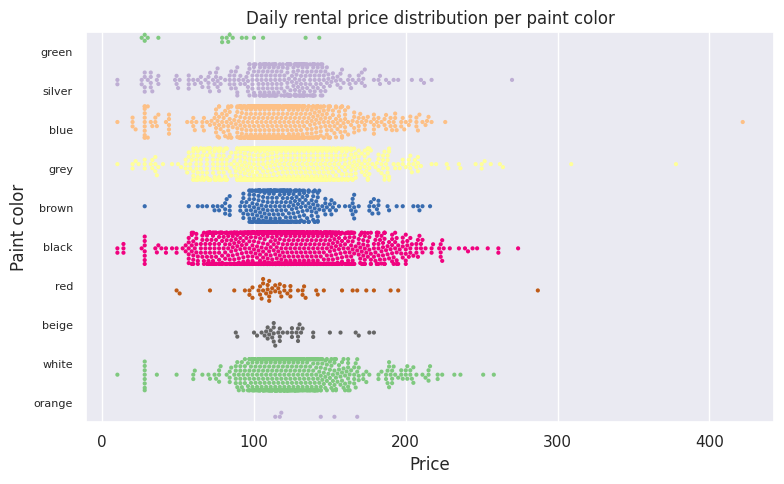

In [111]:
color_means = df.groupby('paint_color')['rental_price_per_day'].mean().sort_values()

# Sort the DataFrame based on mean rental price
df_sorted = df.set_index('paint_color').loc[color_means.index].reset_index()


plt.figure(figsize=(8, 5))

ax = sns.swarmplot(data=df_sorted, x="rental_price_per_day", y='paint_color', dodge=True,palette='Accent', size=3)

plt.xlabel('Price')
plt.ylabel('Paint color')
plt.title('Daily rental price distribution per paint color')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

The above is sorts paint colors by their average rental price in an ascending order.
- Orange cars seems to be the most expensive in average (as can be expected as it's a common color for sports cars) while green is the paint color with the lowest average rental price. Yet neither of these two colors are common in the dataset to make any generalization.
- While silver cars seem less expensive than black cars, there is not a big difference in the price distribution among any of the frequent colors.


#### Fuel type:

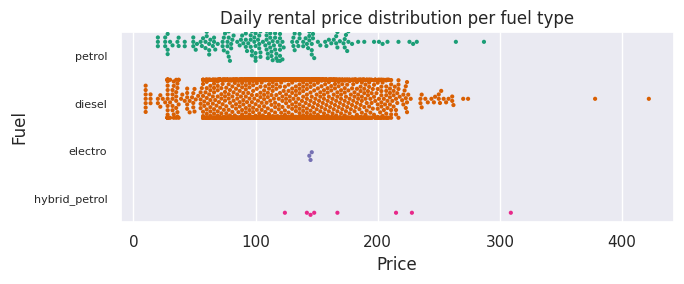

In [115]:
fuel_means = df.groupby('fuel')['rental_price_per_day'].mean().sort_values()

# Sort the DataFrame based on mean rental price
df_sorted = df.set_index('fuel').loc[fuel_means.index].reset_index()


plt.figure(figsize=(7, 3))

ax = sns.swarmplot(data=df_sorted, x="rental_price_per_day", y='fuel', dodge=True,palette='Dark2', size=3)

plt.xlabel('Price')
plt.ylabel('Fuel')
plt.title('Daily rental price distribution per fuel type')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

The above graph sorts fuel types by their average rental price in an ascending order.
- Petrol consuming cars seem to have the lowest average daily rental rates while hybrid and electro cars which are both rare in our sample seem rather more expensive.

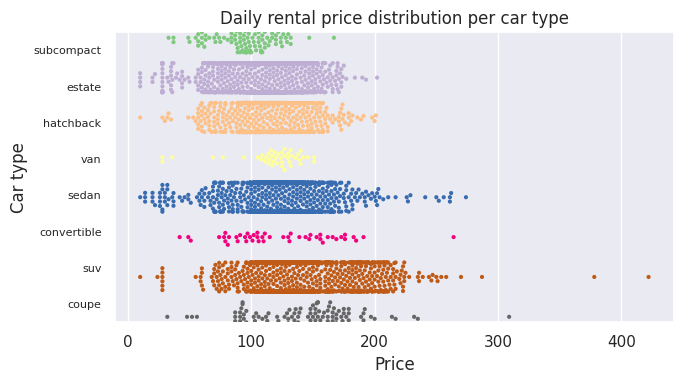

In [116]:
type_means = df.groupby('car_type')['rental_price_per_day'].mean().sort_values()

# Sort the DataFrame based on mean rental price
df_sorted = df.set_index('car_type').loc[type_means.index].reset_index()


plt.figure(figsize=(7, 4))

ax = sns.swarmplot(data=df_sorted, x="rental_price_per_day", y='car_type', dodge=True,palette='Accent', size=3)

plt.xlabel('Price')
plt.ylabel('Car type')
plt.title('Daily rental price distribution per car type')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

The average rental price per car type is shown in an ascending order above.
- Subcompact cars have the lowest average rental price, wheras coupe and SUV models are the top two most expensive types.

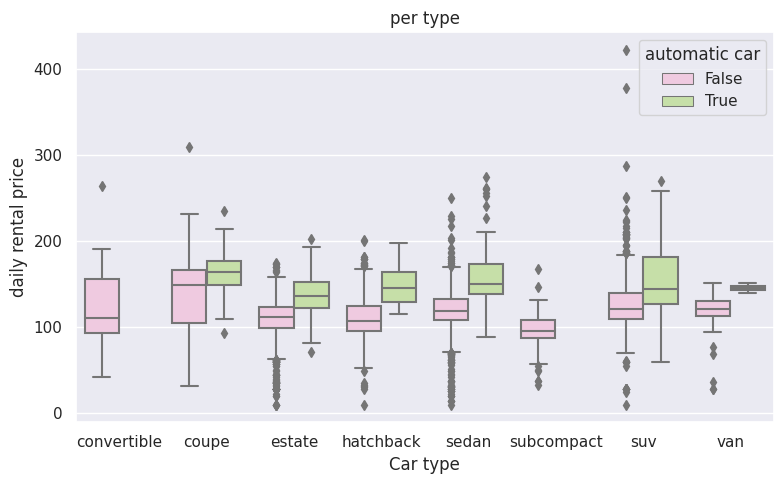

In [33]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='car_type', y='rental_price_per_day', hue='automatic_car', palette='PiYG')

plt.xlabel('Car type')
plt.ylabel('daily rental price')
plt.title('per type')
plt.legend(title='automatic car')

plt.tight_layout()
plt.show()

Regardless of the car type, automatic cars (when available) seems to have a higher average rental price than their manual counterparts.

Let's play with more boolean variables and their interaction with the daily rental price

In [152]:

fig = px.scatter(df[(df['mileage'] < 500000)],
                 x="mileage", y='rental_price_per_day',
                color='automatic_car', hover_name='automatic_car',
                 facet_row = 'has_gps', facet_col = 'private_parking_available')
fig.update_layout(height=450, width=700)  # Adjust these values as needed

fig.show()

- Automatic cars are likely to have a higher daily rental price compared to their manual equivalents in all four cases.
- Having a GPS and having private parking both seem to be factors positively correlated with the price.

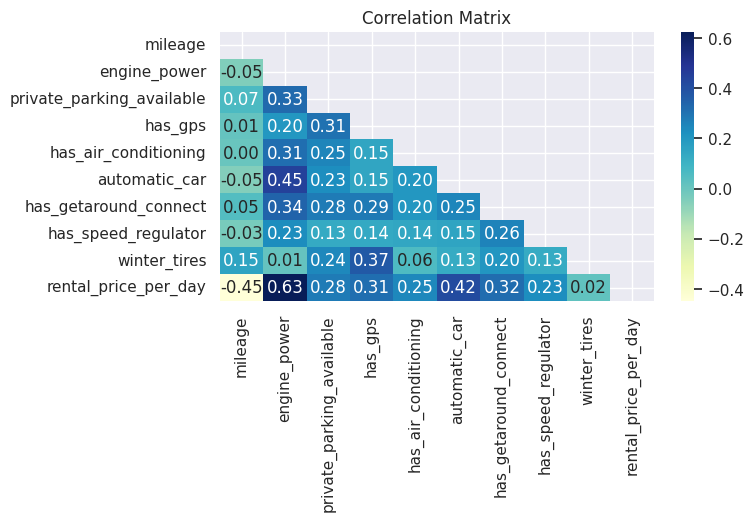

In [34]:
plt.figure(figsize=(7, 3.5))
corr_matrix = df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f", mask=mask)
plt.title('Correlation Matrix')
plt.show()

According to the correlation matrix for the numerical and boolean features of our dataset:
- Engine power and mileage are two factors that display the strongest correlation with the price, while the former has a positive correlation, the latter is negatively correlated.
- They are followed by having automatic transmission, having getaround connect and having gps.
- Having winter tires appears to show a very loose correlation.

YET, this analysis is just for the purposes of intuition. And without taking the car models and types into account, nor making a multilinear regression analysis, we cannot jump into any conclusions!

## PART 2 : DATA PREPROCESSING

### Dropping the Outliers

In [153]:
for column in num_vars:
    lower_bound = df[column].mean() - 3*df[column].std()
    upper_bound = df[column].mean() + 3*df[column].std()
    df = df[(df[column] < upper_bound) & (df[column] > lower_bound) ]
print("The number of observations is",len(df), "after dropping the outliers")


The number of observations is 4750 after dropping the outliers


In [40]:
print("The number of model keys is", len(df['model_key'].unique()), "after dropping the outliers")

The number of model keys is 26 after dropping the outliers


### Optional :  Storing the Cleaned Data in a Data Lake

In [ ]:
session = boto3.Session(aws_access_key_id="YOUR-ACCES-ID",
                        aws_secret_access_key="YOUR-ACCES-KEY")

In [ ]:
s3 = session.resource("s3")
bucket = s3.create_bucket(Bucket="jedha-getaround-project")

pricing_data_cleaned = df.to_csv()
put_object = bucket.put_object(Key="pricing_data_cleaned.csv", Body=pricing_data_cleaned)

### Column Transformations
- Numerical features: scaling
- Categorical and boolean features: one-hot encoding

Let's first split the data into train and test sets.
#### Warning:
Our categorical columns contain a lot of infrequent values. Applying the train-test split before column transformations may risk obtaining a test set that contains categorical values that were not one-hot encoded because that were not in the train-set. To avoid this, you can either split the data after the transformations or make multiple attempts until you find a random seed that would avoid such a problem. random_state = 0 worked fine for this data.

In [154]:
X_train, X_test, Y_train, Y_test = train_test_split(df[features_list], df[target], test_size=0.2, random_state=0)

In [155]:
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('encoder', OneHotEncoder(drop='first'))])
bool_transformer = Pipeline([('encoder', OneHotEncoder(drop='if_binary'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_vars),
        ('cat', cat_transformer, cat_vars),
        ('bool', bool_transformer, bool_vars)  # Add boolean columns
    ])

In [156]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [135]:
preprocessor.transformers_

[('num',
  Pipeline(steps=[('scaler', StandardScaler())]),
  ['mileage', 'engine_power']),
 ('cat',
  Pipeline(steps=[('encoder', OneHotEncoder(drop='first'))]),
  ['model_key', 'fuel', 'paint_color', 'car_type']),
 ('bool',
  Pipeline(steps=[('encoder', OneHotEncoder(drop='if_binary'))]),
  ['private_parking_available',
   'has_gps',
   'has_air_conditioning',
   'automatic_car',
   'has_getaround_connect',
   'has_speed_regulator',
   'winter_tires'])]

In [136]:
column_names = []
for name, transformer, features in preprocessor.transformers_: # loop over pipelines
    if name == 'num':
        features = features
    elif name == 'cat': # if pipeline is for categorical variables
        features = transformer.named_steps['encoder'].get_feature_names_out()
        dropped_car = transformer.named_steps['encoder'].categories_[0][0]
        dropped_fuel = transformer.named_steps['encoder'].categories_[1][0]
        dropped_paint = transformer.named_steps['encoder'].categories_[2][0]
        dropped_type = transformer.named_steps['encoder'].categories_[3][0]
        #note that i stored the dropped labels of the categorical features in new variables in case i may need later

    column_names.extend(features)

## PART 3 : MACHINE LEARNING

### Baseline Regression Model

In [157]:
LR = LinearRegression()
LR.fit(X_train, Y_train)



LinearRegression()

In [158]:

P_train = LR.predict(X_train)
P_test = LR.predict(X_test)

print("Root Mean Squared Error (RMSE) on training set:", np.sqrt(mean_squared_error(Y_train, P_train)))
print("Root Mean Squared Error (RMSE) on test set:", np.sqrt(mean_squared_error(Y_test, P_test)))

print("R2 score on training set : ", r2_score(Y_train, P_train))
print("R2 score on test set : ", r2_score(Y_test, P_test))

Root Mean Squared Error (RMSE) on training set: 18.056987540098113
Root Mean Squared Error (RMSE) on test set: 16.27598331489458
R2 score on training set :  0.6870206285864552
R2 score on test set :  0.739271080077585


In [159]:
coefs = pd.DataFrame(
   LR.coef_.ravel(),
   columns=['Coefficients'], index=column_names)
print('The number of coefficients in our model is',len(coefs))

The number of coefficients in our model is 53


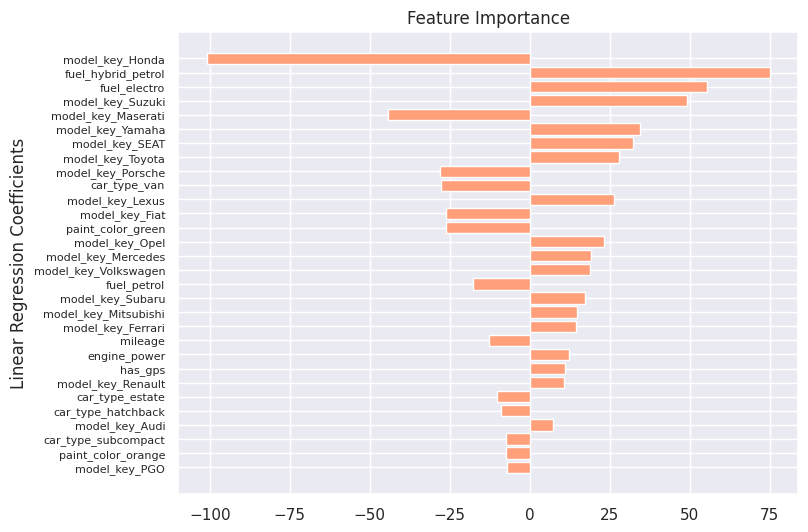

In [160]:
coef_sorted = coefs.assign(Abs_Coefficients=abs(coefs['Coefficients'])).sort_values(by='Abs_Coefficients', ascending=True)

# Plotting the top 30 coefficients with the original values
plt.figure(figsize=(8, 6))
plt.barh(coef_sorted[-30:].index, coef_sorted[-30:]['Coefficients'], color='lightsalmon')

plt.ylabel('Linear Regression Coefficients')
plt.title('Feature Importance')
plt.yticks(fontsize=8)
plt.show()

In [161]:
dropped_car

'Alfa Romeo'

- Our baseline model has reached an R2 score of 0.69 on the training set, and 0.74 (yes, interestingly higher) on the test set.
- One can try to increase the train set size to improve the performance on the training set but the test set size was already 0.2, so I will not narrow it any further.
- In terms of the coefficients, model type overall seem to be an important determinant. On the other hand, it would be wrong to conclude that the model type is the most important feature just by looking at the absolute values of coefficients and seeing model_key_Honda with the highest value. This is because of the particular interpretation of coefficients in linear regression.
- The coefficients assigned to each model type in fact tells us 'with every other feature being equal' how much a price of a Honda (or Audi, or Mistibushi) in average differs from an Alfa Romeo (base category) with the exact same characteristics.
- Therefore, it would be wrong to make any inference on the impact of model other than comparing the model coefficients with each other in their magnitudes and sizes. With this logic, we can tell that Honda in average has a lower price than an Alfa Romeo with the same features, while with everything else equal (which is in reality not always possible), Suzuki would be the model which has the highest price.
- The same applies for other categorical features like fuel, car type and paint color.
- If we look at the numerical and boolean features mileage, engine power and gps seem as the important features.

### Decision Tree

In [162]:
DTR = DecisionTreeRegressor(max_depth=15, min_samples_leaf=10,
                       min_samples_split=5, splitter='random',random_state = 0)
DTR.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=15, min_samples_leaf=10, min_samples_split=5,
                      random_state=0, splitter='random')

In [163]:
P_train = DTR.predict(X_train)
P_test = DTR.predict(X_test)


print("Root Mean Squared Error (RMSE) on training set:", np.sqrt(mean_squared_error(Y_train, P_train)))
print("Root Mean Squared Error (RMSE) on test set:", np.sqrt(mean_squared_error(Y_test, P_test)))

print("R2 score on training set : ", r2_score(Y_train, P_train))
print("R2 score on test set : ", r2_score(Y_test, P_test))

Root Mean Squared Error (RMSE) on training set: 17.487533130991388
Root Mean Squared Error (RMSE) on test set: 19.520503088486663
R2 score on training set :  0.7064499100232394
R2 score on test set :  0.6249607287406496


- Decision Tree model showed a slight performance improvement on the training set while achieveing a much lower R2 score for the test set.

### Random Forest

In [164]:
RFR = RandomForestRegressor(n_estimators = 45, max_depth=15, min_samples_leaf= 2,
                            min_samples_split=3,random_state=0,n_jobs= -1)
RFR.fit(X_train,Y_train.values.ravel())


RandomForestRegressor(max_depth=15, min_samples_leaf=2, min_samples_split=3,
                      n_estimators=45, n_jobs=-1, random_state=0)

In [165]:
P_train = RFR.predict(X_train)
P_test = RFR.predict(X_test)

print("Root Mean Squared Error (RMSE) on training set:", np.sqrt(mean_squared_error(Y_train, P_train)))
print("Root Mean Squared Error (RMSE) on test set:", np.sqrt(mean_squared_error(Y_test, P_test)))

print("R2 score on training set : ", r2_score(Y_train, P_train))
print("R2 score on test set : ", r2_score(Y_test, P_test))

Root Mean Squared Error (RMSE) on training set: 10.034486497662265
Root Mean Squared Error (RMSE) on test set: 15.0101621785309
R2 score on training set :  0.9033469811972269
R2 score on test set :  0.7782490429314592


- Compared to our baseline model, random forest model achieved a much higher score on the train set and also a decent improvement on the test set!

### SVM

In contrast to other machine learning models, it is a well common practice to apply scaling also on the target variable when dealing with Support Vector Regressors. See more at:
https://medium.com/swlh/support-vector-regression-explained-for-beginners-2a8d14ba6e5d
https://medium.com/@vk.viswa/support-vector-regression-unleashing-the-power-of-non-linear-predictive-modeling-d4495836884

I tried both scaled and unscaled Y variables while training the model and the predictive performance on both sets was better when the targets are scaled.

In [166]:
sc_y = StandardScaler()
Y_train = sc_y.fit_transform(Y_train)


In [167]:
SVR_ = SVR(kernel = 'rbf',C=1, degree=3, gamma = 'scale', epsilon = 0.1)
SVR_.fit(X_train, Y_train.ravel())


SVR(C=1)

In [168]:
P_train = SVR_.predict(X_train)
P_test = sc_y.inverse_transform(SVR_.predict(X_test).reshape(-1,1))

print("Root Mean Squared Error (RMSE) on training set:", np.sqrt(mean_squared_error(Y_train, P_train)))
print("Root Mean Squared Error (RMSE) on test set:", np.sqrt(mean_squared_error(Y_test, P_test)))

print("R2 score on training set : ", r2_score(Y_train, P_train))
print("R2 score on test set : ", r2_score(Y_test, P_test))

Root Mean Squared Error (RMSE) on training set: 0.4724336343454344
Root Mean Squared Error (RMSE) on test set: 15.616009668198664
R2 score on training set :  0.7768064611391644
R2 score on test set :  0.7599869410454891


The model reached a decent performance on both sets, though lower than the Random Forest Regressor.

Let's check out the feature importance.

For non-linear SVMs, since there are no coefficients, one technique to explore the feature importance is permutation importance, where you shuffle each feature independently and observe how much the performance of the model decreases.

Features that lead to a larger decrease in performance when shuffled might be considered more important. In fact, this offers a better insight than simply looking at the regression coefficients.

In [59]:
perm_importance = permutation_importance(SVR_, X_test.toarray(), Y_test)


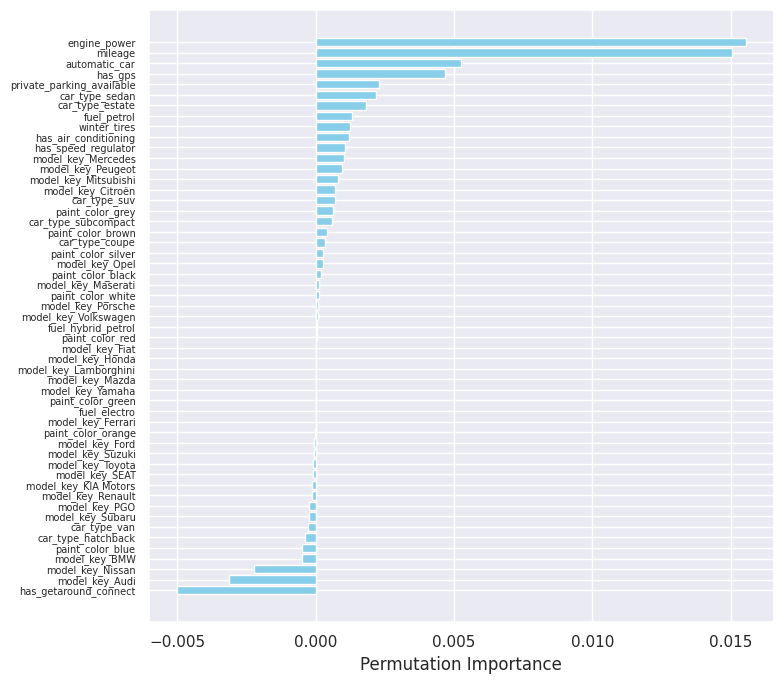

In [65]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(8, 7))  # Set the size of the figure (width=8 inches, height=6 inches)


plt.barh(np.array(column_names)[sorted_idx], perm_importance.importances_mean[sorted_idx], color='skyblue')
plt.xlabel("Permutation Importance")
plt.yticks(fontsize=7)
plt.tight_layout()  # Adjust layout if necessary
plt.show()

Permutation importance approach seems to have compensated for the misleading impact of a mere coefficient analysis. Here, we can indeed see that engine power, mileage or automatic transmission are more important in price estimation than the model type.

Having a negative permutation importance score means that the model performance has improved in the absence of that feature. In our case, having get_around_connect does not seem to contribute much to the predictive power of the model.

## XGBoost

In [169]:
X_train, X_test,Y_train, Y_test = train_test_split(df[features_list], df[target].astype(int), test_size= 0.2, random_state = 0)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

XGB = xgb.XGBRegressor(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=230,
    colsample_bytree=0.8,
    subsample=1,
    reg_lambda=0.8,
    random_state =0
    )
XGB.fit(X_train,Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=230, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [170]:
P_train = XGB.predict(X_train)
P_test = XGB.predict(X_test)


print("Root Mean Squared Error (RMSE) on training set:", np.sqrt(mean_squared_error(Y_train, P_train)))
print("Root Mean Squared Error (RMSE) on test set:", np.sqrt(mean_squared_error(Y_test, P_test)))

print("R2 score on training set : ", r2_score(Y_train, P_train))
print("R2 score on test set : ", r2_score(Y_test, P_test))

Root Mean Squared Error (RMSE) on training set: 9.508419015315997
Root Mean Squared Error (RMSE) on test set: 14.098091123056506
R2 score on training set :  0.9132155848554647
R2 score on test set :  0.8043790515385272


The XGBoost model reached the best performance on both sets so far!

## PART 4 : MODEL SELECTION
In the code below, I will perform some random train-test splits and cross-validations to test the robustness of performances achieved above.

In particular,
- I will perform ten random train-test split and train each of these 5 algorithms from scratch on ten different train sets.
- then for each of the 50 trained models I will perform 10-fold cross validation on the corresponding test set of that iteration.
- In total, I will obtain 500 RSME and R2 scores.

In [171]:
models = {LR : 'Linear Regression',
          DTR : 'Decision Tree',
          RFR: 'Random Forest',
          SVR_ : 'Support Vector Machine',
          XGB : 'XGBoost'}



model_performance = {}

model_performance['model_name'] = []
model_performance['rmse'] = []
model_performance['r2'] = []

for model in models.keys():

  for i in range(10):
    X = preprocessor.fit_transform(df[features_list])
    X_train, X_test, Y_train, Y_test = train_test_split(X, df[target], test_size=0.2)

    if model == SVR_:
      Y_train = sc_y.fit_transform(Y_train)
      Y_test = sc_y.transform(Y_test)
      model.fit(X_train, Y_train.ravel())

      rsme_test = cross_val_score(estimator = model, X = X_test, y = Y_test.ravel(), cv = 10, scoring= 'neg_root_mean_squared_error').tolist()
      r2_test =  cross_val_score(estimator = model, X = X_test, y = Y_test.ravel(), cv = 10, scoring= 'r2').tolist()

    elif model == RFR:
      model.fit(X_train, Y_train.values.ravel())
      rsme_test = cross_val_score(estimator = model, X = X_test, y = Y_test.values.ravel(), cv = 10, scoring= 'neg_root_mean_squared_error').tolist()
      r2_test =  cross_val_score(estimator = model, X = X_test, y = Y_test.values.ravel(), cv = 10, scoring= 'r2').tolist()

    else:
      model.fit(X_train, Y_train)
      rsme_test = cross_val_score(estimator = model, X = X_test, y = Y_test, cv = 10, scoring= 'neg_root_mean_squared_error').tolist()
      r2_test =  cross_val_score(estimator = model, X = X_test, y = Y_test, cv = 10, scoring= 'r2').tolist()

    model_performance['model_name']+= [models[model]] * 10
    model_performance['rmse']+= np.abs(rsme_test).tolist()
    model_performance['r2']+= r2_test





In [172]:
model_performance = pd.DataFrame(model_performance)
len(model_performance)

500

The dataset has 500 rows as we expected. Let's visualize some statistics on the model performances.

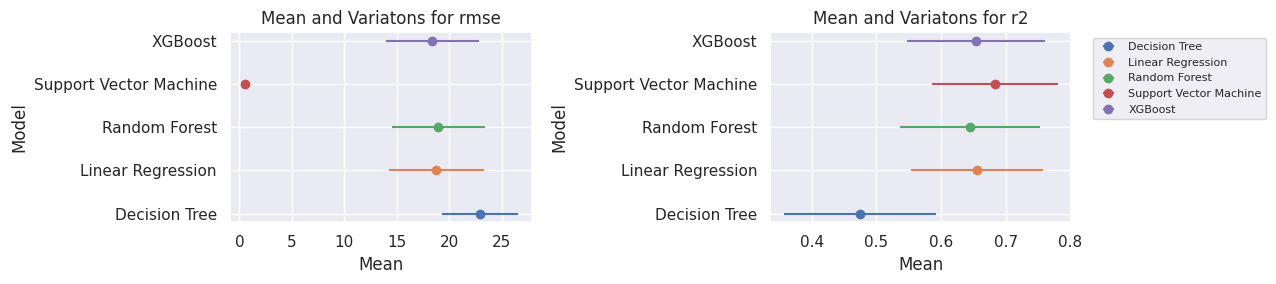

In [173]:
num_models = len(set(model_performance['model_name']))

fig, axes = plt.subplots(1, 2, figsize=(13, 3))
for i, score in enumerate(model_performance.columns[1:]):
    ax = axes[i]

    # Iterate over unique model names
    for j, model in enumerate(sorted(set(model_performance['model_name']))):

        model_data = model_performance[model_performance['model_name'] == model]

        # Plot error bars for the specific model and score
        ax.errorbar(y=j, x=model_data[score].mean(), xerr=model_data[score].std(),
                    fmt='o', label=model)

    # Set plot title and labels
    ax.set_title(f"Mean and Variatons for {score}")
    ax.set_ylabel('Model')
    ax.set_xlabel('Mean')

    # Set x-axis labels as model names
    ax.set_yticks(range(num_models))
    ax.set_yticklabels(sorted(set(model_performance['model_name'])))  # Set model names as x-axis labels

    # Show legend for each subplot
ax.legend(bbox_to_anchor=(1.05, 1), prop={'size': 8},loc='upper left')

plt.tight_layout()
plt.show()

- In terms of the R2-score Decision Tree fall far behind other 4 models.
- SVM has the best average performancei followed by XGBoost and Linear Regression only with a small difference.
- On the other hand, if we look at the RMSE score, interestingly SVM outperformed the other 4 models with a root-mean-squared-error near zero.
- Let's display the values to make sure :

In [ ]:
model_performance[model_performance['model_name']== 'Support Vector Machine' ].head(6)

,model_name,rmse,r2
300,Support Vector Machine,0.433418,0.731856
301,Support Vector Machine,0.493402,0.708542
302,Support Vector Machine,0.577637,0.578491
303,Support Vector Machine,0.463269,0.740459
304,Support Vector Machine,0.614039,0.573207
305,Support Vector Machine,0.486479,0.710769
306,Support Vector Machine,0.504811,0.724896
307,Support Vector Machine,0.973787,0.423309
308,Support Vector Machine,0.527103,0.658651
309,Support Vector Machine,0.576502,0.677533


It looks indeed that error in the SVM predictions are quite low.
Therefore, I will go with the SVM model for deployment.

## PART 5 : DEPLOYMENT

### Preparation for Deployment
- 1. Since I applied scaling also on the target variable,I must make sure the outputs of the model is unscaled back.
- 2. I'll train the model on the entire dataset before deployment.

There are several possible ways to make sure that the output is unscaled.
- 1. one is to create an unscaler pipeline and apply it to the model predictions
- 2. another is build a custom SVR model that contains unscaler and train that model
- I picked the second option. So in the cell below I created a new class that calls for scikit-learn's SVR class with the SVR hyperparameters I tuned and for Standard Scalar class.
- The fit function of the model makes sure that scaler objects trains on and transform the target variable Y before it goes to the SVR object. SVR object trains on this scaled targets then.
- Finally, the built-in predict function of the custom class return the final output after unscaling the predictions of SVR model.


In [ ]:
class SVR_with_InverseScaler(BaseEstimator):
    def __init__(self, scaler=StandardScaler(), svr=SVR(kernel='rbf', C=1, degree=3, gamma='scale', epsilon=0.1)):
        self.scaler = scaler
        self.svr = svr

    def fit(self, X, y):
        y_scaled = self.scaler.fit_transform(y)  # Scale the target variable
        self.svr.fit(X, y_scaled.ravel())  # Fit the model with scaled target variable
        return self

    def predict(self, X):
        scaled_predictions = self.svr.predict(X)
        unscaled_predictions = self.scaler.inverse_transform(scaled_predictions.reshape(-1, 1)).flatten()
        return unscaled_predictions


Now let's train the model on the entire dataset

In [ ]:
X, Y = df[features_list], df[target]

In [ ]:
X = preprocessor.fit_transform(X)

In [ ]:
SVR_model = SVR_with_InverseScaler()
SVR_model.fit(X,Y)

SVR_with_InverseScaler()

In [ ]:
Preds = SVR_model.predict(X)
print("R2 score on the entire dataset : ", r2_score(Y, Preds))

R2 score on the entire dataset :  0.7841578035948961


Let's try out the model with a new imaginary example vehicle.

In [174]:
example_car = {
  "model_key": "Porsche",
  "mileage": 30000,
  "engine_power": 220,
  "fuel": "diesel",
  "paint_color": "black",
  "car_type": "sedan",
  "private_parking_available": True,
  "has_gps": False,
  "has_air_conditioning": True,
  "automatic_car": False,
  "has_getaround_connect": True,
  "has_speed_regulator": True,
  "winter_tires": True
  }
example_df = pd.DataFrame([example_car])


In [ ]:
X  = preprocessor.transform(example_df)

In [ ]:
pred = SVR_model.predict(X)
print('The model predicts the rental price of this car as', pred[0],'$ per day.')

The model predicts the rental price of this car as 187.07583181261413 $ per day.


It looks like the model is fine. We are ready to dump the model.

### Dumping to Pickle Objects

In [ ]:
joblib.dump(SVR_model,'api/svr_model.pkl')
joblib.dump(preprocessor,'api/preprocessor.pkl')

['api/preprocessor.pkl']

# Bonus: After Deployment
After having our api deployed, let's test it by sending an exmaple request to see what response we will get.

In [68]:
import requests
url = 'https://getraound-api-7d58c833a433.herokuapp.com/predict'
request_pred = requests.post(url,
                             json={ "model_key": "Honda",
                                   "mileage": 40000,
                                    "engine_power": 180,
                                    "fuel": "electro",
                                    "paint_color": "blue",
                                    "car_type": "convertible",
                                    "private_parking_available": True,
                                    "has_gps": True,
                                    "has_air_conditioning": True,
                                    "automatic_car": False,
                                    "has_getaround_connect": False,
                                    "has_speed_regulator": True,
                                    "winter_tires": False })
print(f"Rental price prediction for this car : {round(request_pred.json()['prediction'],2)} $")

Rental price prediction for this car : 177.62 $


### It works !